# Week 1

## Data Cleaning and Feature Engineering using Python

This notebook demonstrates how we cleaned and validated the SLU Opportunity Wise dataset and performed feature engineering inspired by Excel-based logic provided in the task instructions.

## Tasks Covered:

### 1. Data Loading  
- Load raw dataset into a pandas DataFrame.

### 2. Data Cleaning and Validation  
- **Handling Missing Values**: Imputed or removed nulls in key fields like `Institution Name`, `Apply Date`.  
- **Handling Outliers**: Addressed anomalies in date columns via safe datetime coercion.  
- **Standardizing Formats**: Unified string casing, spacing, and formatting for consistency.  
- **Correcting Errors**: Mapped similar city names (e.g., "St. Louis" → "Saint Louis") and cleaned random text in `Major`.  
- **Dealing with Duplicates**: Removed exact duplicates to maintain data integrity.  
- **Handling Inconsistent Categorical Data**: Standardized values in columns like `Gender`.

### 3. Feature Engineering  
- **Age Calculation**: Derived from `Date of Birth`.  
- **Engagement Duration**: Days between `Apply Date` and `Opportunity Start Date`.  
- **Time in Opportunity**: Duration from `Opportunity Start` to `End`.  
- **Date-Based Features**: Extracted `SignUp Month` and `SignUp Year`.  
- **Normalization**: Scaled continuous features to 0–1 range.  
- **Encoding Categorical Data**: Converted `Gender` into binary (`Gender_Male`).


 *This cleaned and feature-enriched dataset is now ready for further EDA and predictive modeling.*


# 1.Loading Dataset

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# Load dataset

df = pd.read_csv("/content/SLU Opportunity Wise Data-1710158595043 - SLU Opportunity Wise Data-1710158595043.csv")
df.head()

,Learner SignUp DateTime,Opportunity Id,Opportunity Name,Opportunity Category,Opportunity End Date,First Name,Date of Birth,Gender,Country,Institution Name,Current/Intended Major,Entry created at,Status Description,Status Code,Apply Date,Opportunity Start Date
0,06/14/2023 12:30:35,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,06/29/2024 18:52:39,Faria,01/12/2001,Female,Pakistan,Nwihs,Radiology,03/11/2024 12:01:41,Started,1080,06/14/2023 12:36:09,11/03/2022 18:30:39
1,05/01/2023 05:29:16,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,06/29/2024 18:52:39,Poojitha,08/16/2000,Female,India,SAINT LOUIS,Information Systems,03/11/2024 12:01:41,Started,1080,05/01/2023 06:08:21,11/03/2022 18:30:39
2,04/09/2023 20:35:08,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,06/29/2024 18:52:39,Emmanuel,01/27/2002,Male,United States,Illinois Institute of Technology,Computer Science,03/11/2024 12:01:41,Started,1080,05/11/2023 1085640:21:29,11/03/2022 18:30:39
3,08/29/2023 05:20:03,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,06/29/2024 18:52:39,Amrutha Varshini,11/01/1999,Female,United States,Saint Louis University,Information Systems,03/11/2024 12:01:41,Team Allocated,1070,10/09/2023 22:02:42,11/03/2022 18:30:39
4,01/06/2023 15:26:36,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,06/29/2024 18:52:39,Vinay Varshith,04/19/2000,Male,United States,Saint Louis University,Computer Science,03/11/2024 12:01:41,Started,1080,01/06/2023 15:40:10,11/03/2022 18:30:39


# 2.Data Cleaning and Validation

In [ ]:
# Initialize df_cleaned with the original dataframe
df_cleaned = df.copy()

# 1. Handling Missing Values
df_cleaned = df_cleaned.assign(
    **{'Institution Name': df_cleaned['Institution Name'].fillna('Unknown')}
)

# 2. Handling Outliers (via datetime parsing — invalids become NaT)
date_fields = [
    'Learner SignUp DateTime', 'Opportunity End Date', 'Date of Birth',
    'Entry created at', 'Apply Date', 'Opportunity Start Date'
]
for col in date_fields:
    df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors='coerce')

# 3. Standardizing Formats
df_cleaned['Gender'] = df_cleaned['Gender'].str.strip().str.title()
df_cleaned['Country'] = df_cleaned['Country'].str.strip().str.title()
df_cleaned['Institution Name'] = df_cleaned['Institution Name'].str.strip().str.title()
df_cleaned['Current/Intended Major'] = df_cleaned['Current/Intended Major'].str.strip().str.title()

# 4. Correcting Errors
# Normalize common institution variations
df_cleaned['Institution Name'] = df_cleaned['Institution Name'].replace({
    'St. Louis': 'Saint Louis',
    'Saint Louis University': 'Saint Louis'
})
# Remove junk characters from majors
df_cleaned['Current/Intended Major'] = df_cleaned['Current/Intended Major'].replace(
    to_replace=r'[^a-zA-Z\s]', value='', regex=True
)
# Fill empty major strings with 'Unknown'
df_cleaned['Current/Intended Major'] = df_cleaned['Current/Intended Major'].replace('', 'Unknown')

# 5. Dealing with Duplicates
df_cleaned = df_cleaned.drop_duplicates()

# 6. Handling Inconsistent Categorical Data
# Fix gender encoding inconsistencies
df_cleaned['Gender'] = df_cleaned['Gender'].replace({'F': 'Female', 'M': 'Male'})
df_cleaned['Gender'] = df_cleaned['Gender'].where(df_cleaned['Gender'].isin(['Male', 'Female']), 'Other')

#  Safe Imputation of Apply Date with Entry Created At
df_cleaned['Apply Date'] = df_cleaned['Apply Date'].fillna(df_cleaned['Entry created at'])

# Drop rows with critical missing dates (cannot compute features without them)
df_cleaned = df_cleaned.dropna(subset=[
    'Opportunity Start Date', 'Opportunity End Date', 'Apply Date', 'Learner SignUp DateTime'
])

#  Summary Output
print(" Cleaned dataset shape:", df_cleaned.shape)
print("Remaining nulls after cleaning:")
print(df_cleaned.isnull().sum().sort_values(ascending=False))


 Cleaned dataset shape: (3368, 16)
Remaining nulls after cleaning:
Current/Intended Major     1
Learner SignUp DateTime    0
Opportunity Name           0
Opportunity Id             0
Opportunity End Date       0
First Name                 0
Date of Birth              0
Opportunity Category       0
Gender                     0
Country                    0
Institution Name           0
Entry created at           0
Status Description         0
Status Code                0
Apply Date                 0
Opportunity Start Date     0
dtype: int64


# 3.Feature Engineering

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 1. Age Calculation from Date of Birth
df_cleaned['Age'] = df_cleaned['Date of Birth'].apply(
    lambda x: datetime.now().year - x.year if pd.notnull(x) else np.nan
)

# 2. Engagement Duration = Apply Date - Opportunity Start Date
df_cleaned['Engagement Duration (Days)'] = (
    df_cleaned['Apply Date'] - df_cleaned['Opportunity Start Date']
).dt.days

# 3. Time in Opportunity = Opportunity End Date - Opportunity Start Date
df_cleaned['Time in Opportunity (Days)'] = (
    df_cleaned['Opportunity End Date'] - df_cleaned['Opportunity Start Date']
).dt.days

# 4. Extract SignUp Month and SignUp Year from SignUp Date
df_cleaned['SignUp Month'] = df_cleaned['Learner SignUp DateTime'].dt.month
df_cleaned['SignUp Year'] = df_cleaned['Learner SignUp DateTime'].dt.year

# 5. Normalize Numerical Features: Age, Engagement Duration, Time in Opportunity
scaler = MinMaxScaler()
norm_cols = ['Age', 'Engagement Duration (Days)', 'Time in Opportunity (Days)']
df_cleaned[norm_cols] = scaler.fit_transform(df_cleaned[norm_cols])

# 6. Encode Gender to Binary (Male = 1, Female = 0, Other = -1)
df_cleaned['Gender_Male'] = df_cleaned['Gender'].apply(
    lambda x: 1 if x == 'Male' else (0 if x == 'Female' else -1)
)

#  Feature Engineering Completed
print("Feature engineering completed.")
print(df_cleaned[['Age', 'Engagement Duration (Days)', 'Time in Opportunity (Days)',
                  'SignUp Month', 'SignUp Year', 'Gender_Male']].head())


Feature engineering completed.
        Age  Engagement Duration (Days)  Time in Opportunity (Days)  \
0  0.204545                    0.667892                     0.66413   
1  0.227273                    0.613971                     0.66413   
2  0.181818                    1.000000                     0.66413   
3  0.250000                    0.812500                     0.66413   
4  0.227273                    0.473039                     0.66413   

   SignUp Month  SignUp Year  Gender_Male  
0             6         2023            0  
1             5         2023            0  
2             4         2023            1  
3             8         2023            0  
4             1         2023            1  


# 4.Export And Download Clean CSV in Google Collab

In [ ]:
# Step 1: Export to CSV (in Colab's file system)
output_path = "/content/Team_E_Week1_Cleaned_Featured_Data.csv"
df_cleaned.to_csv(output_path, index=False)
print(f"Dataset exported successfully to: {output_path}")

# Step 2: Trigger download in browser (Colab)
from google.colab import files
files.download(output_path)


Dataset exported successfully to: /content/Team_E_Week1_Cleaned_Featured_Data.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4. Feature Examples
This section demonstrates how engineered features were calculated using Python, supported by real-world-style examples to explain their interpretation and analytical value.

### 1. Age at Signup

In [ ]:
df_cleaned['Age'] = df_cleaned['Date of Birth'].apply(
    lambda x: datetime.now().year - x.year if pd.notnull(x) else np.nan
)

**Explanation:** Calculates each learner’s age at the time of processing by subtracting the birth year from the current year. If the birth date is missing, the function returns NaN.

**Example:**
- Learner: Nirmal
- Date of Birth: 1998-04-20
- Assumed Current Date: 2025-03-23
- Result: 26 years
- Excel Equivalent: =DATEDIF(1998-04-20, 2025-03-23, "Y")

**Interpretation:** Nirmal is 26 years old. This feature allows grouping learners by age (e.g., <18, 18–24, 25–34), useful for targeted program design.

### 2. Engagement Duration (Days)

In [ ]:
df_cleaned['Engagement Duration (Days)'] = (
    df_cleaned['Apply Date'] - df_cleaned['Opportunity Start Date']
).dt.days

**Explanation:** Calculates the number of days between a learner’s application date and the opportunity start date. Positive values suggest late applications, while negative values suggest early ones.

**Example:**
- Learner: Sujita
- Apply Date: 2023-08-10
- Opportunity Start Date: 2023-08-05
- Result: +5 days

**Interpretation:** Sujita applied 5 days after the program began. This may be flagged as a late application and can be used to analyze learner responsiveness.

### 3. Time in Opportunity (Days)

In [ ]:
df_cleaned['Time in Opportunity (Days)'] = (
    df_cleaned['Opportunity End Date'] - df_cleaned['Opportunity Start Date']
).dt.days

**Explanation:** Calculates the total number of days an opportunity lasts by subtracting the start date from the end date.

**Example:**
- Opportunity: Digital Skills Bootcamp
- Start Date: 2022-01-01
- End Date: 2022-06-30
- Result: 180 days

**Interpretation:** The program runs for 6 months. This metric helps compare opportunity durations and group them as short-term or long-term learning experiences.

### 4. Signup to Start Delay (Days)

In [ ]:
df_cleaned['Signup to Start Delay'] = (
    df_cleaned['Opportunity Start Date'] - df_cleaned['Learner SignUp DateTime']
).dt.days

**Explanation:** Measures how many days in advance a learner signed up before the opportunity began.

**Example:**
- Learner: Kritika
- Signup Date: 2023-04-01
- Opportunity Start Date: 2023-04-20
- Result: 19 days

**Interpretation:** Kritika signed up 19 days early, indicating proactive behavior. This feature can help predict learner commitment and allow for early outreach.

### 5. Gender_Male Encoding

In [ ]:
df_cleaned['Gender_Male'] = df_cleaned['Gender'].apply(
    lambda x: 1 if x == 'Male' else (0 if x == 'Female' else -1)
)

**Explanation:** Converts categorical gender data into a numeric format:

- Male → 1
- Female → 0
- Other/Unknown → -1

**Example:**
- Learner Gender: Female
- Result: 0

**Interpretation:** This binary encoding allows easy filtering and inclusion in models for gender-based analysis while maintaining data standardization.

# Week 2

# Complete Exploratory Data Analysis (EDA) Report

This notebook covers the full process of Exploratory Data Analysis (EDA) based on the uploaded dataset. It includes:
- Data Understanding and Exploration
- Relationship Discovery
- Data Visualization Techniques
- Outlier Detection
- Insight Generation and Hypothesis Development
- Preparation for Predictive Modeling

Each step is aligned with best practices for AI-powered analytics.


In [ ]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step 1: Load and Explore the Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
df = pd.read_excel('modified_dataset-Copy1.xlsx')

In [ ]:
# Step 2: Preview the data
print(df.head())           # first 5 rows

  Learner SignUp DateTime                  Opportunity Id  \
0     2023-05-01 16:33:21  00000000-0GN2-A0AY-7XK8-C5FZPP   
1     2023-05-01 16:32:39  00000000-0GN2-A0AY-7XK8-C5FZPP   
2     2023-05-01 16:33:12  00000000-0GN2-A0AY-7XK8-C5FZPP   
3     2023-05-01 16:32:31  00000000-0GN2-A0AY-7XK8-C5FZPP   
4     2023-05-01 16:32:38  00000000-0GN2-A0AY-7XK8-C5FZPP   

                                    Opportunity Name Opportunity Category  \
0  Career Essentials: Getting Started with Your P...               Course   
1  Career Essentials: Getting Started with Your P...               Course   
2  Career Essentials: Getting Started with Your P...               Course   
3  Career Essentials: Getting Started with Your P...               Course   
4  Career Essentials: Getting Started with Your P...               Course   

  Opportunity End Date            First Name Date of Birth  Gender  Country  \
0  2024-06-29 18:52:39        Mehraj Hussain    2001-06-06    Male    India   
1  2024-06-2

## Step 2 - Visualising Numeric Data

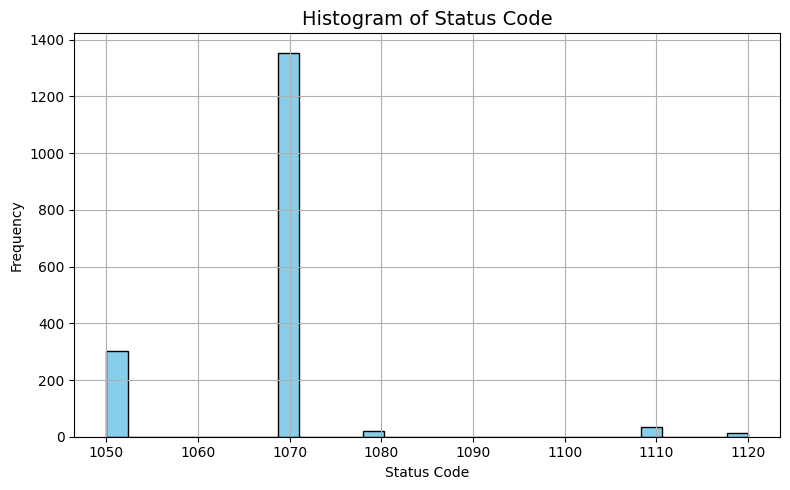

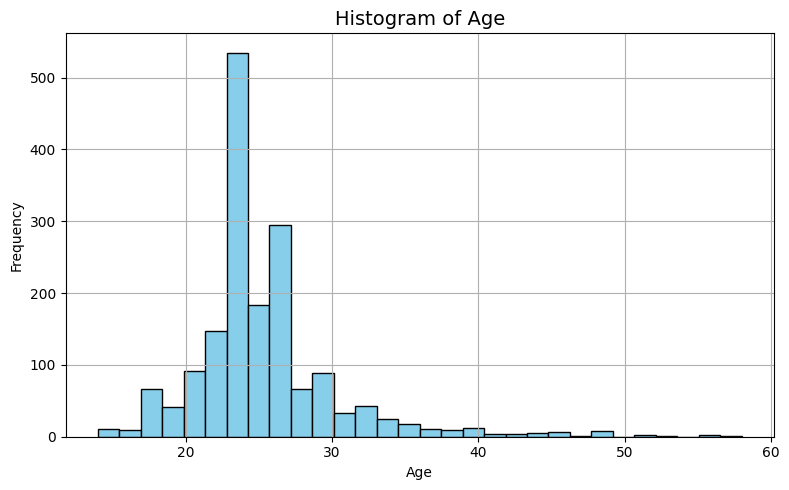

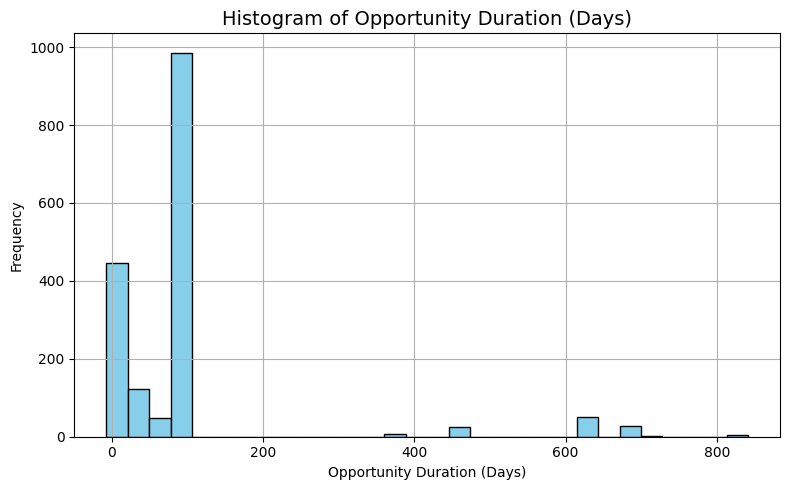

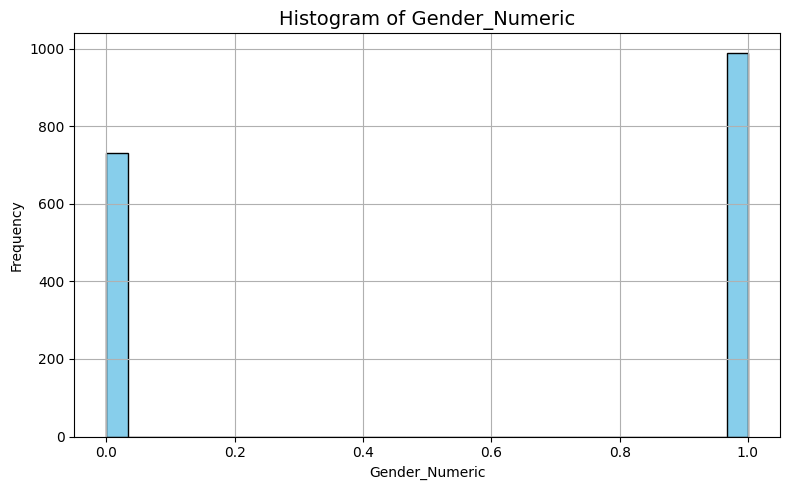

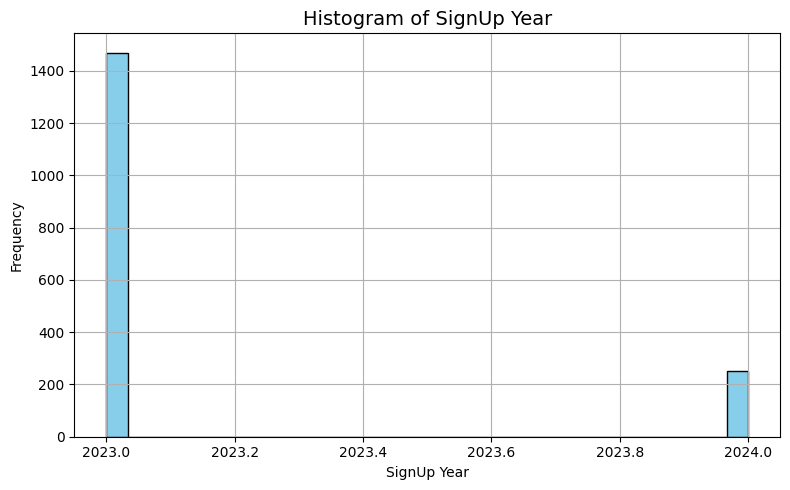

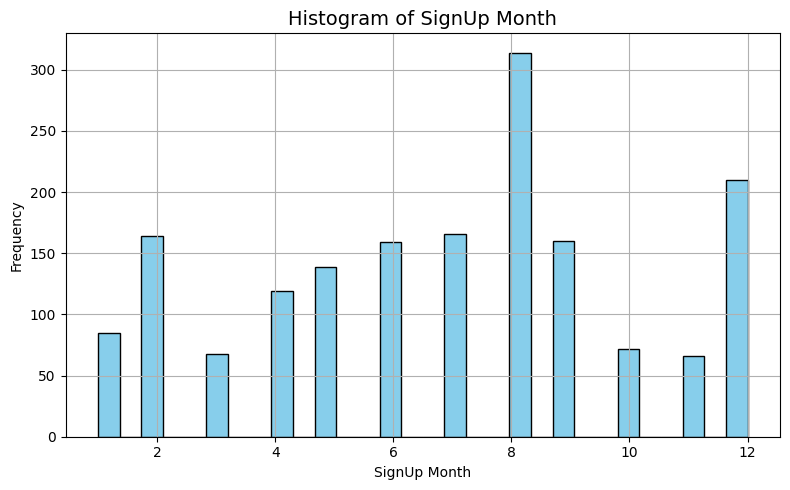

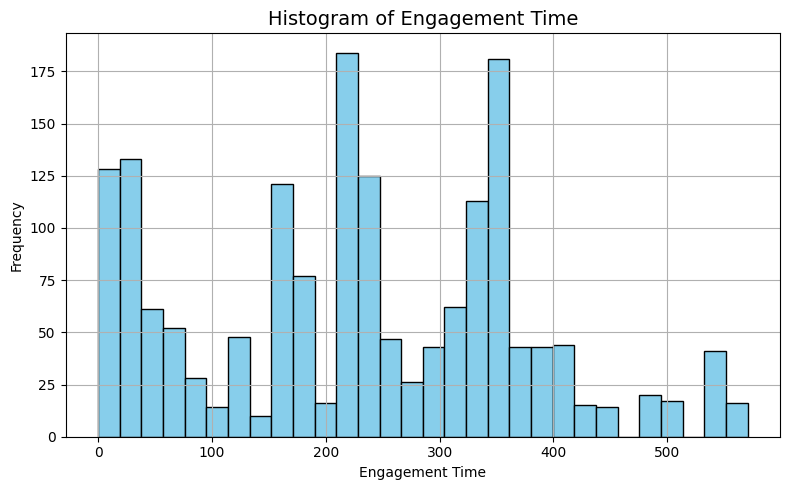

In [ ]:
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Loop through each column and plot a separate histogram
for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    plt.hist(df[col].dropna(), bins=30, edgecolor='black', color='skyblue')
    plt.title(f'Histogram of {col}', fontsize=14)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# Create daily signup counts
daily_signups = df.groupby(df['Learner SignUp DateTime'].dt.date).size()
daily_signups = daily_signups.rename('signups').reset_index()
daily_signups.columns = ['date', 'signups']


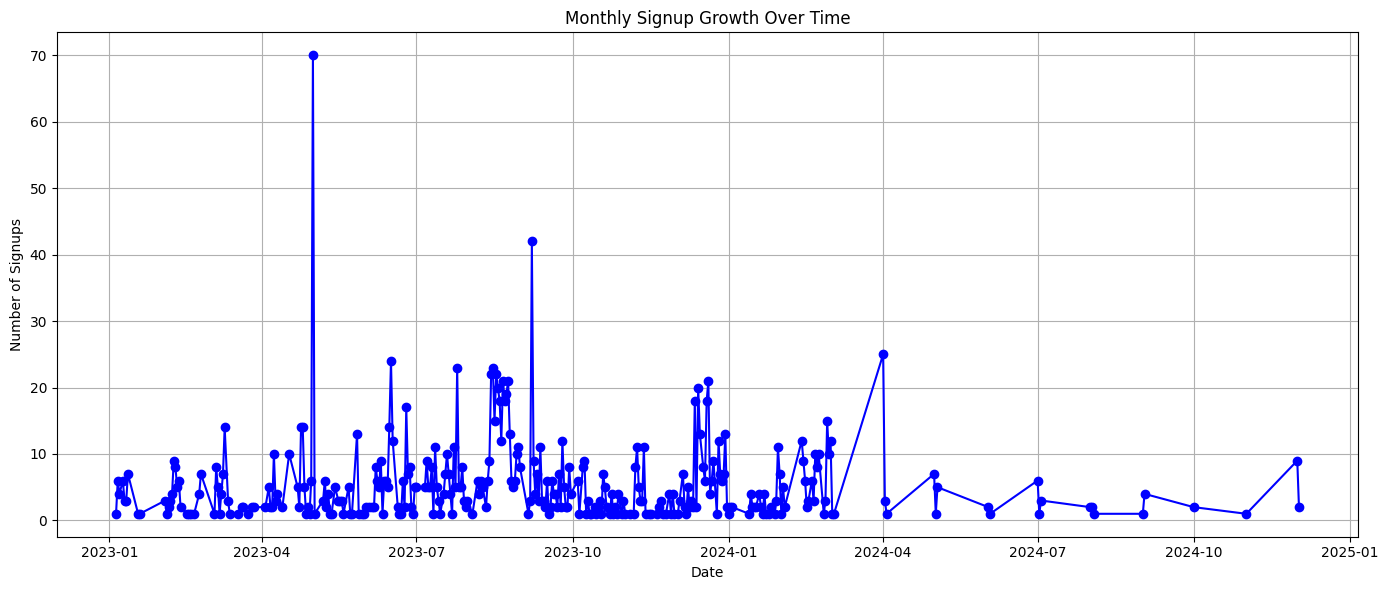

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(daily_signups['date'], daily_signups['signups'], marker='o', linestyle='-', color='blue')
plt.title('Monthly Signup Growth Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Signups')
plt.grid(True)
plt.tight_layout()
plt.show()


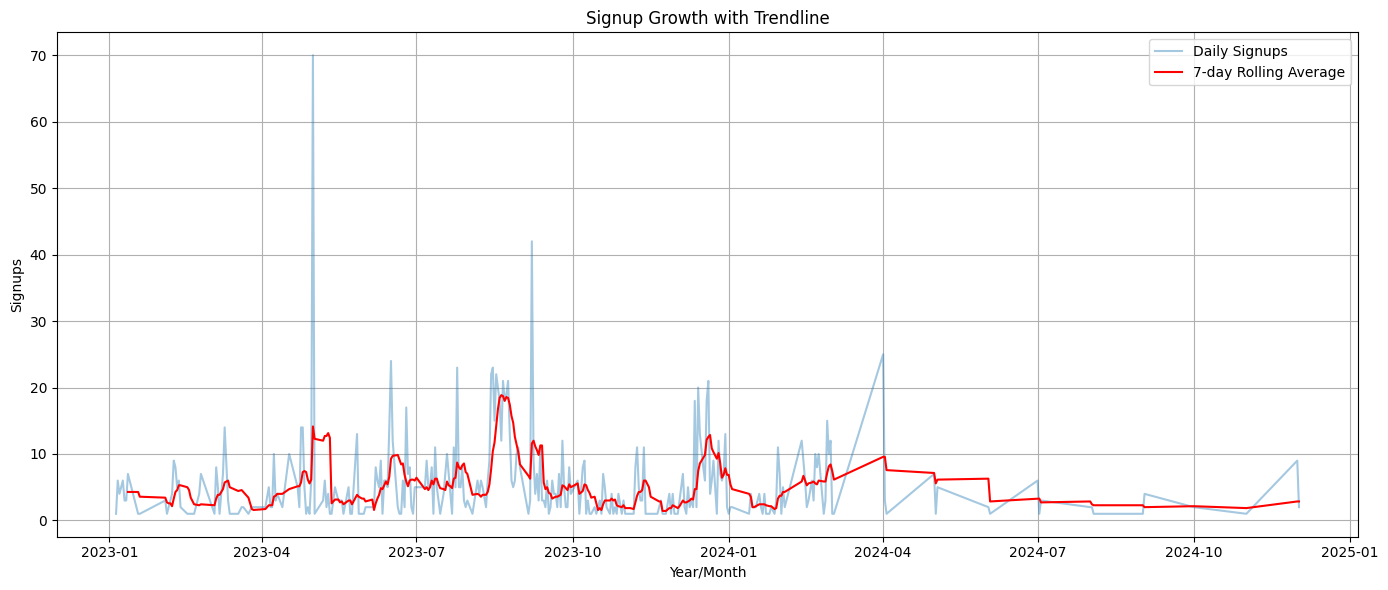

In [ ]:
daily_signups['rolling_avg'] = daily_signups['signups'].rolling(7).mean()

plt.figure(figsize=(14, 6))
plt.plot(daily_signups['date'], daily_signups['signups'], alpha=0.4, label='Daily Signups')
plt.plot(daily_signups['date'], daily_signups['rolling_avg'], color='red', label='7-day Rolling Average')
plt.title('Signup Growth with Trendline')
plt.xlabel('Year/Month')
plt.ylabel('Signups')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


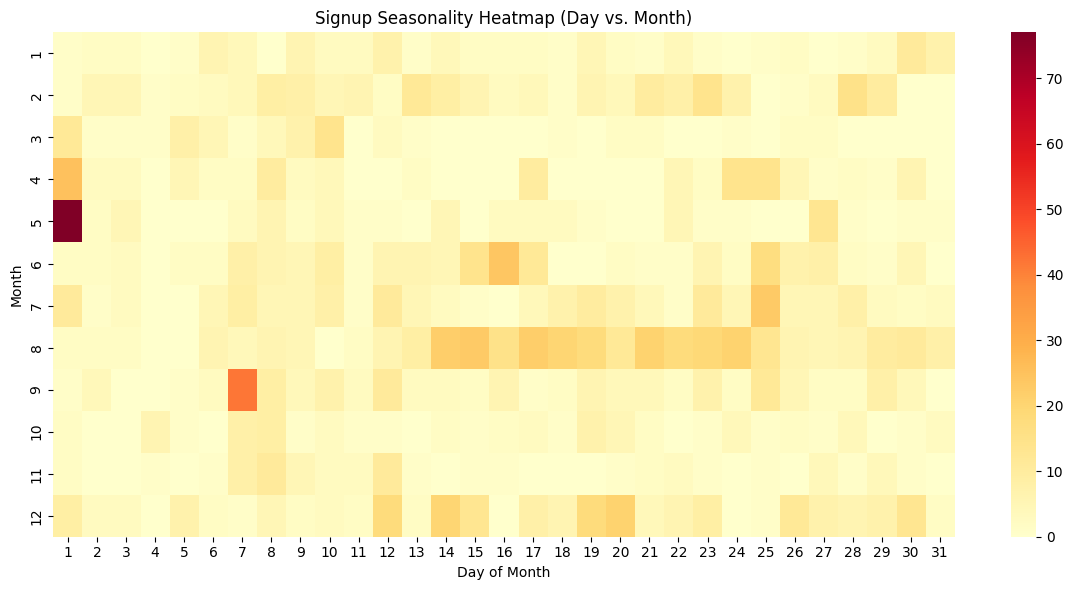

In [ ]:
df['month'] = df['Learner SignUp DateTime'].dt.month
df['day'] = df['Learner SignUp DateTime'].dt.day

heatmap_data = df.groupby(['month', 'day']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd')
plt.title("Signup Seasonality Heatmap (Day vs. Month)")
plt.xlabel("Day of Month")
plt.ylabel("Month")
plt.tight_layout()
plt.show()


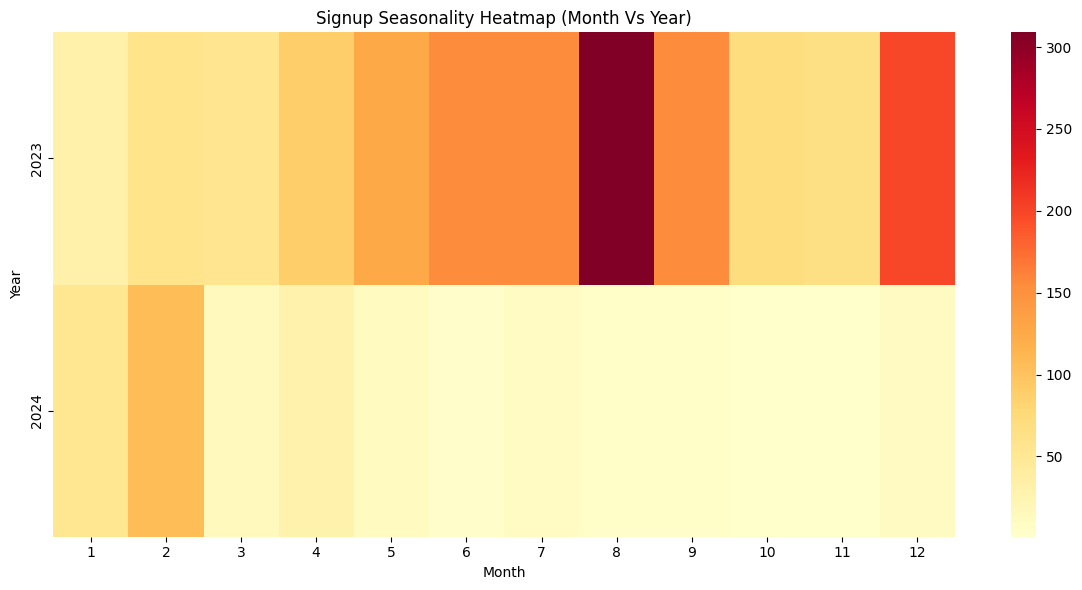

In [ ]:
df['month'] = df['Learner SignUp DateTime'].dt.month
df['year'] = df['Learner SignUp DateTime'].dt.year

heatmap_data = df.groupby([ 'year','month']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd')
plt.title("Signup Seasonality Heatmap (Month Vs Year)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

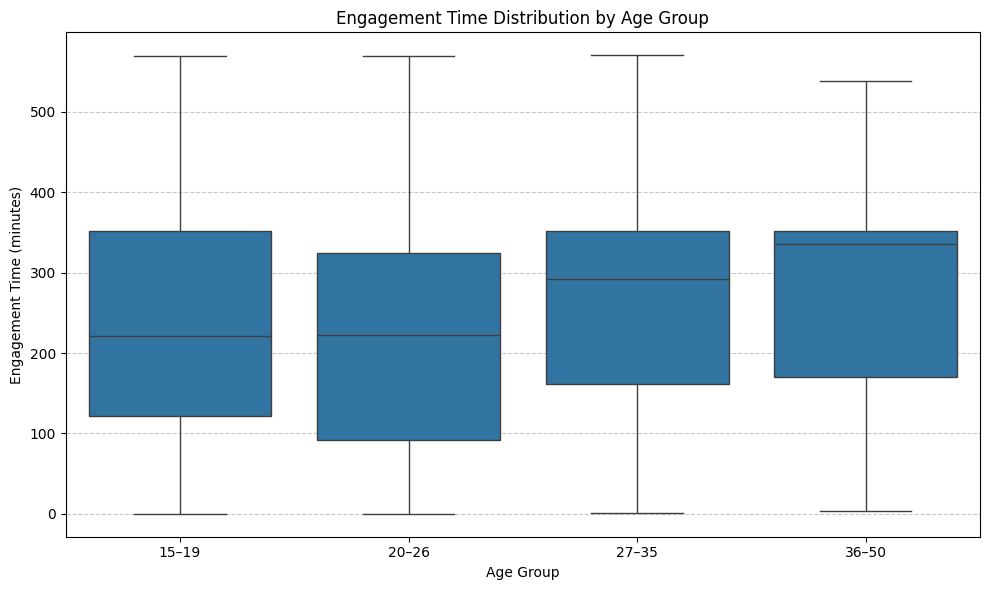

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Age group bins (if not already done)
bins = [15, 19, 26, 35, 50]
labels = ['15–19', '20–26', '27–35', '36–50']
df['age_group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='age_group', y='Engagement Time', data=df)
plt.title('Engagement Time Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Engagement Time (minutes)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


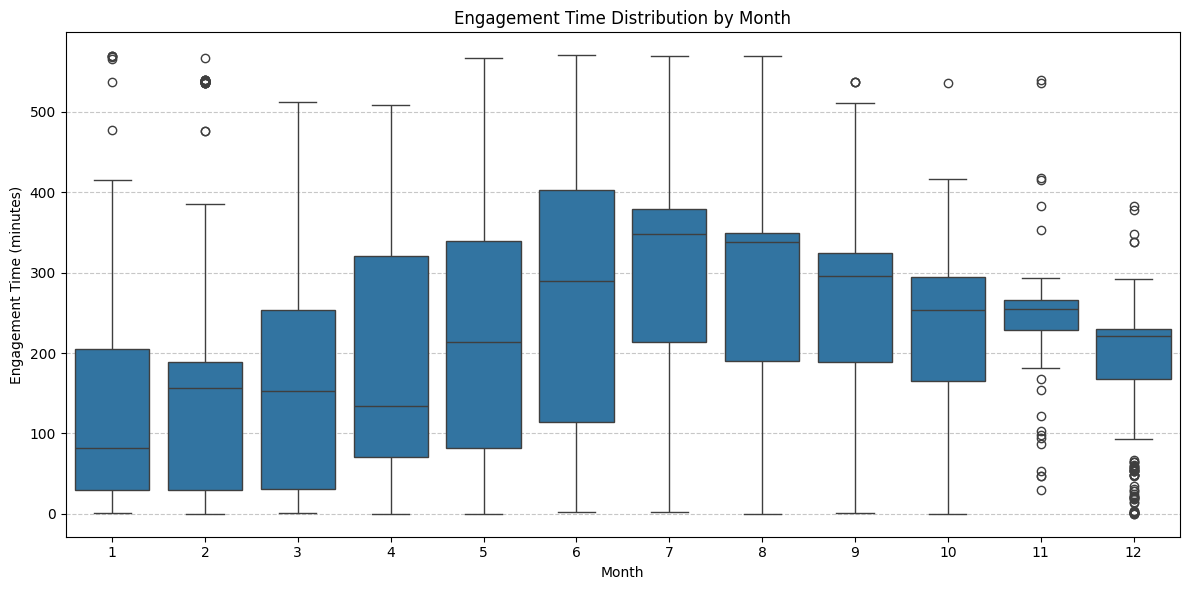

In [ ]:
# Extract month
df['month'] = df['Learner SignUp DateTime'].dt.month

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='Engagement Time', data=df)
plt.title('Engagement Time Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Engagement Time (minutes)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


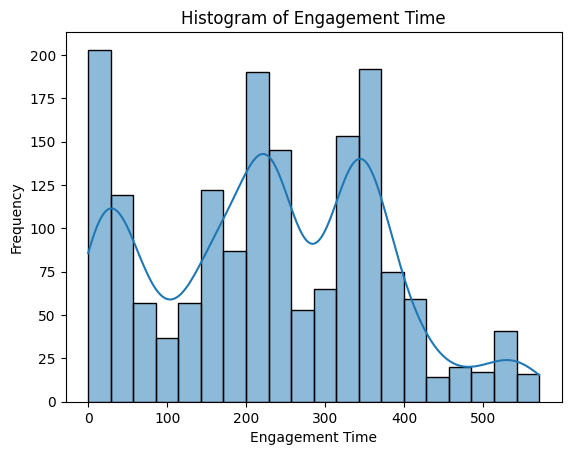

In [ ]:

sns.histplot(df['Engagement Time'], bins=20, kde=True)
plt.title('Histogram of Engagement Time')
plt.xlabel('Engagement Time')
plt.ylabel('Frequency')
plt.show()


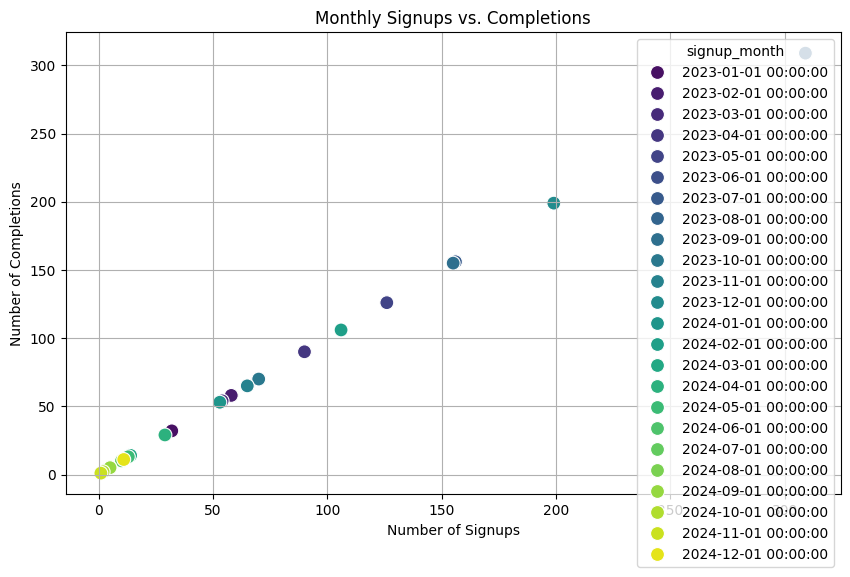

In [ ]:


# Add month-year columns
df['signup_month'] = df['Learner SignUp DateTime'].dt.to_period('M')
df['completion_flag'] = df['Apply Date'].notna().astype(int)

# Group by month
monthly_stats = df.groupby('signup_month').agg(
    signups=('Opportunity Id', 'count'),
    completions=('completion_flag', 'sum')
).reset_index()

# Convert signup_month to datetime for plotting
monthly_stats['signup_month'] = monthly_stats['signup_month'].dt.to_timestamp()

# Plot scatter
plt.figure(figsize=(10,6))
sns.scatterplot(data=monthly_stats, x='signups', y='completions', hue='signup_month', palette='viridis', s=100)
plt.title('Monthly Signups vs. Completions')
plt.xlabel('Number of Signups')
plt.ylabel('Number of Completions')
plt.grid(True)
plt.show()


In [ ]:
# Calculate Pearson correlation
correlation = monthly_stats['signups'].corr(monthly_stats['completions'])

print(f"Correlation between Signups and Completions: {correlation:.2f}")


Correlation between Signups and Completions: 1.00


## Step 3 : Check for Missing Values and Initial Statistics

In [ ]:
# Missing values
missing = df.isnull().sum()
missing[missing > 0]

,0


In [ ]:
# Summary statistics
df.describe(include='all')

,Learner SignUp DateTime,Opportunity Id,Opportunity Name,Opportunity Category,Opportunity End Date,First Name,Date of Birth,Gender,Country,Institution Name,Current/Intended Major,Entry created at,Status Description,Status Code,Apply Date,Opportunity Start Date,Age,Opportunity Duration (Days),Gender_Numeric,SignUp Year,SignUp Month,SignUp Month Name,Engagement Time
count,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722.000000,1722,1722,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722,1722.000000
unique,1197,17,16,5,13,1104,1060,2,41,701,207,62,5,NaN,1657,13,NaN,NaN,NaN,NaN,NaN,12,NaN
top,2023-05-01 16:33:15,00000000-0GRA-BD28-CXVV-EYEX21,Health Care Management,Internship,2024-11-03 18:00:00,John,2002-02-26 00:00:00,Male,United States,Saint Louis University,Information Systems,2024-11-03 12:02:04,Team Allocated,NaN,2023-08-29 05:30:24,2024-08-01 03:30:46,NaN,NaN,NaN,NaN,NaN,August,NaN
freq,51,447,447,986,986,14,9,990,670,444,352,84,1355,NaN,64,986,NaN,NaN,NaN,NaN,NaN,314,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1067.706156,NaN,NaN,25.297909,99.257259,0.574913,2023.146341,6.865273,NaN,228.721254
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.694623,NaN,NaN,5.061859,145.394303,0.494500,0.353551,3.226015,NaN,142.593685
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1050.000000,NaN,NaN,14.000000,-7.000000,0.000000,2023.000000,1.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1070.000000,NaN,NaN,23.000000,-1.000000,0.000000,2023.000000,4.000000,NaN,122.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1070.000000,NaN,NaN,24.000000,94.000000,1.000000,2023.000000,7.000000,NaN,226.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1070.000000,NaN,NaN,27.000000,94.000000,1.000000,2023.000000,9.000000,NaN,343.000000


## Step 4 : Outlier Detection and Data Distributions

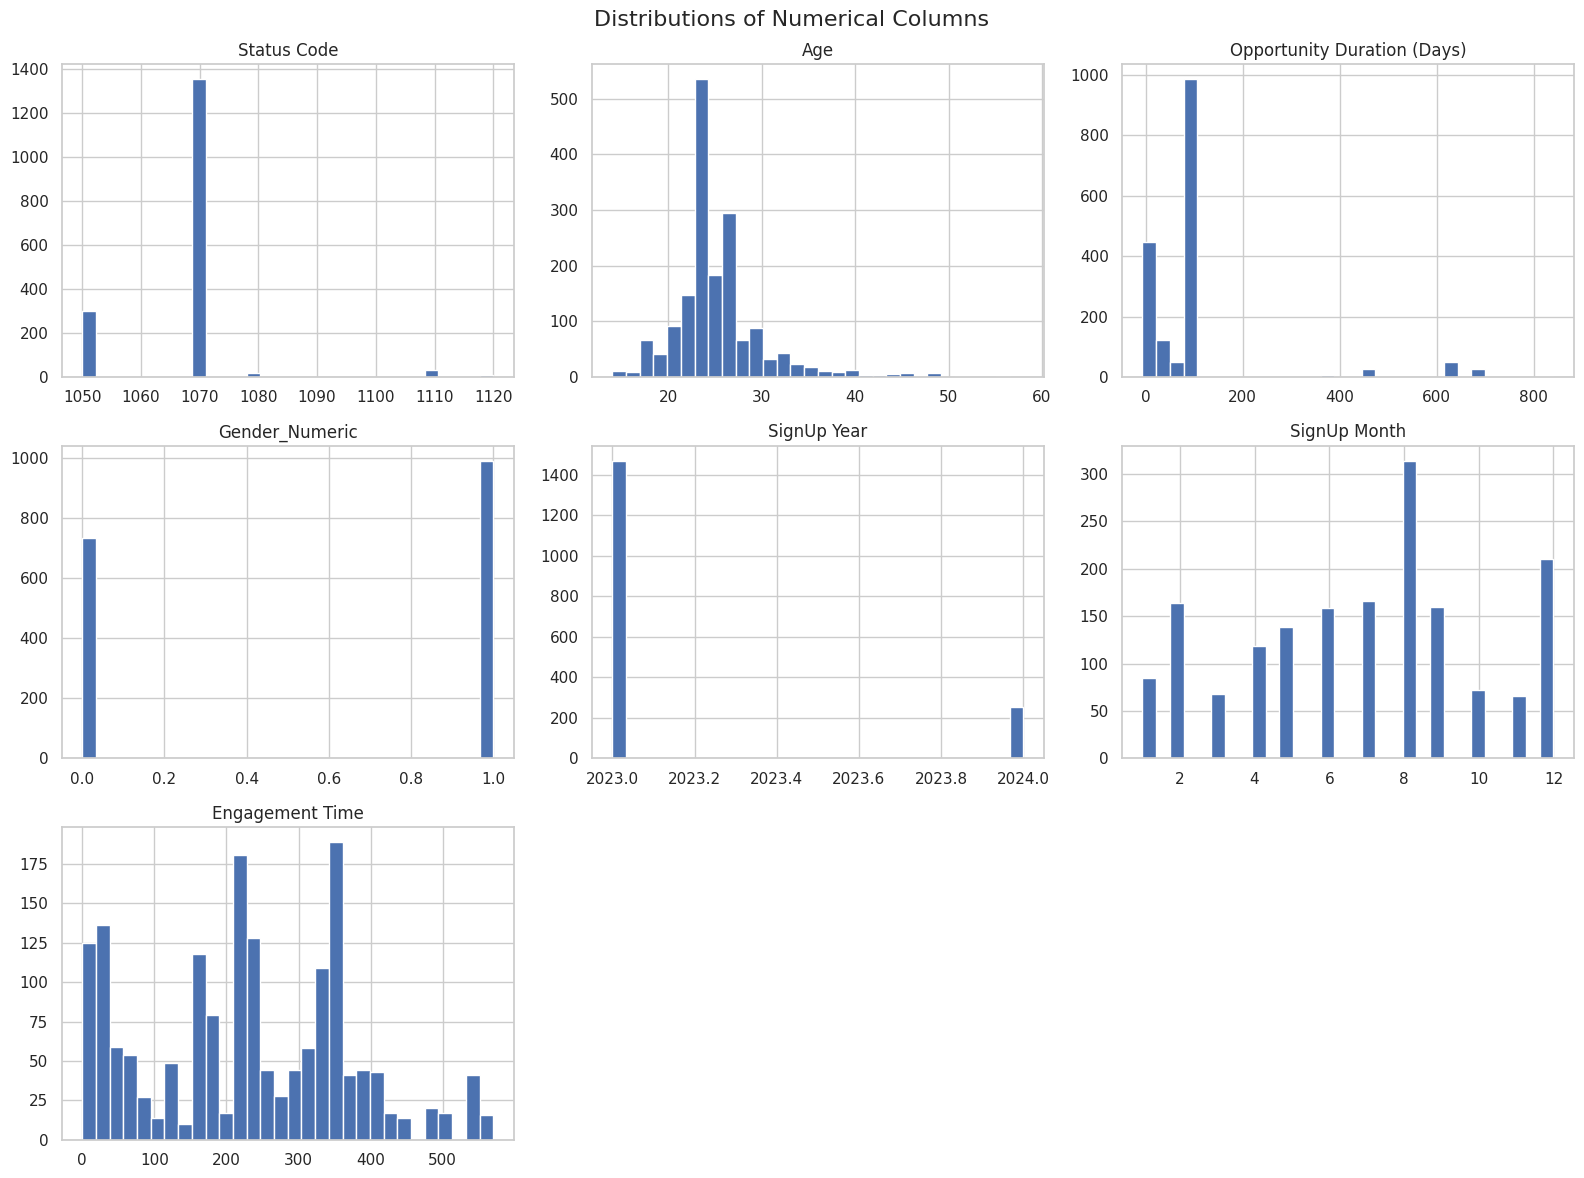

In [ ]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Histograms
df[numerical_cols].hist(bins=30, figsize=(16, 12))
plt.suptitle("Distributions of Numerical Columns", fontsize=16)
plt.tight_layout()
plt.show()

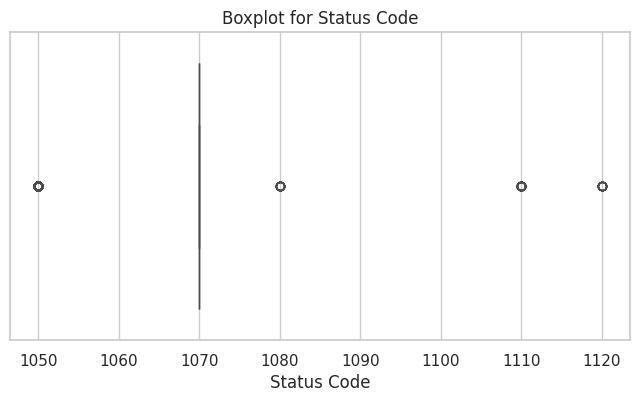

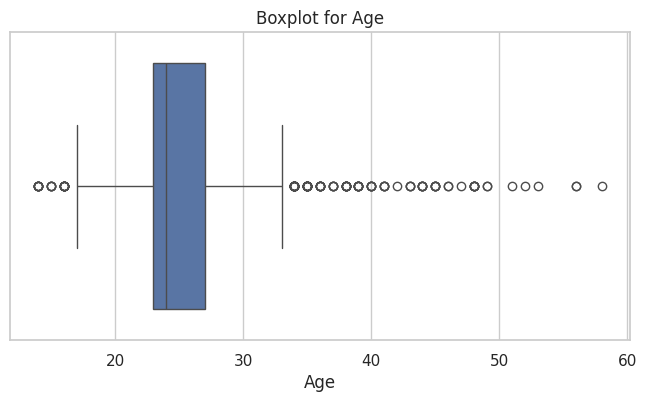

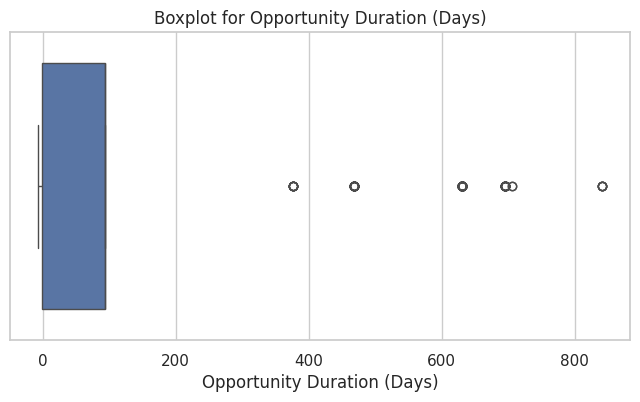

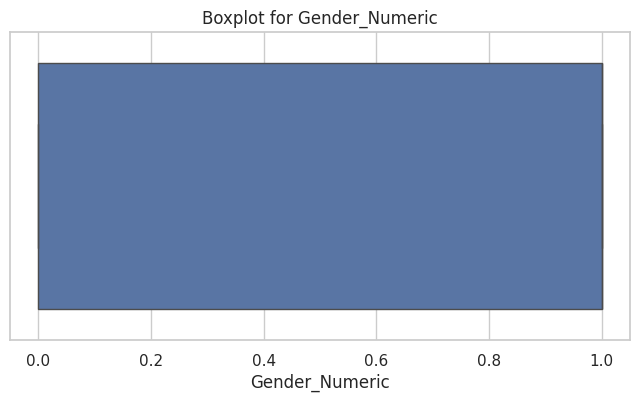

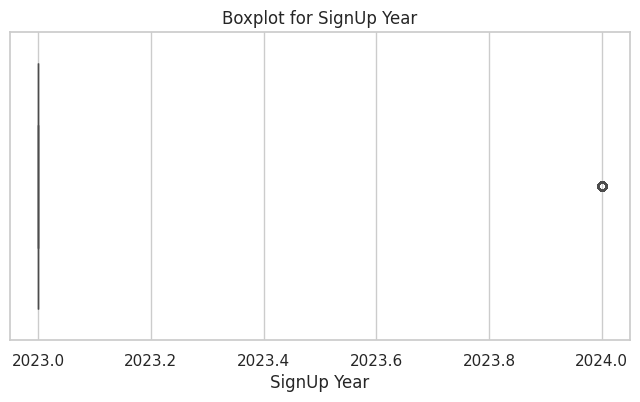

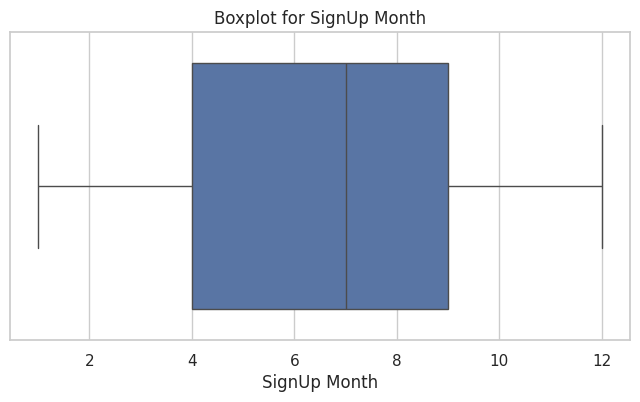

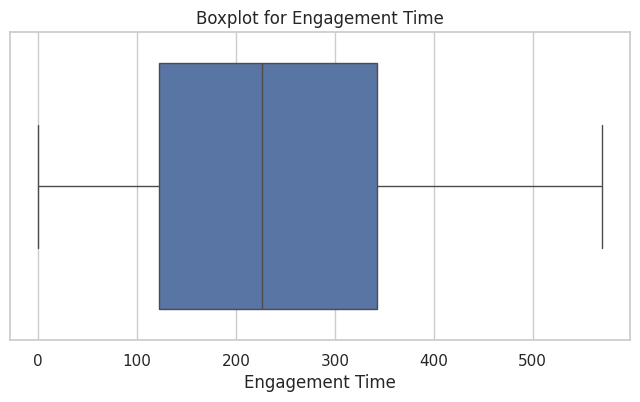

In [ ]:
# Boxplots for outlier detection
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

## Step 5 : Check for Inconsistencies

In [ ]:
# Duplicates
df.duplicated().sum()

np.int64(0)

In [ ]:
# Check data types and convert if necessary
df.dtypes

,0
Learner SignUp DateTime,object
Opportunity Id,object
Opportunity Name,object
Opportunity Category,object
Opportunity End Date,object
First Name,object
Date of Birth,object
Gender,object
Country,object
Institution Name,object


## Step 6 : Analyze Categorical Variables

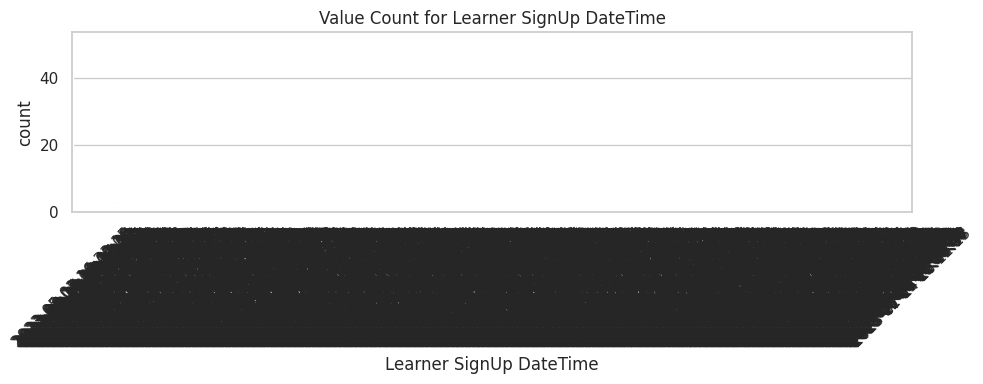

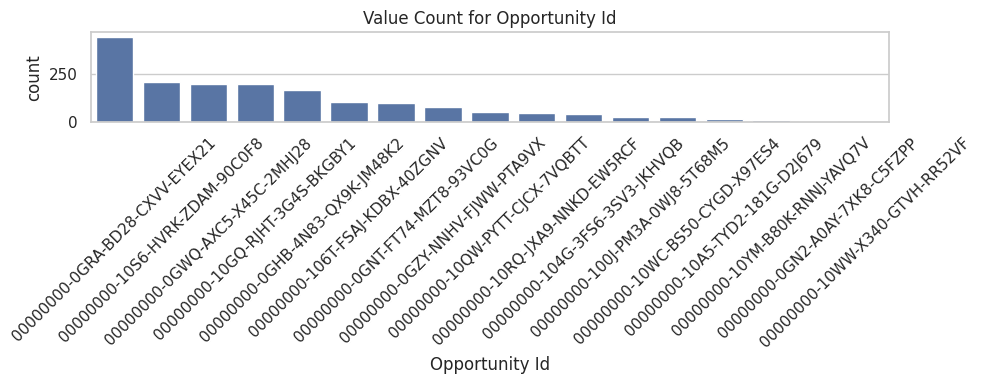

<ipython-input-8-d88663863851>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


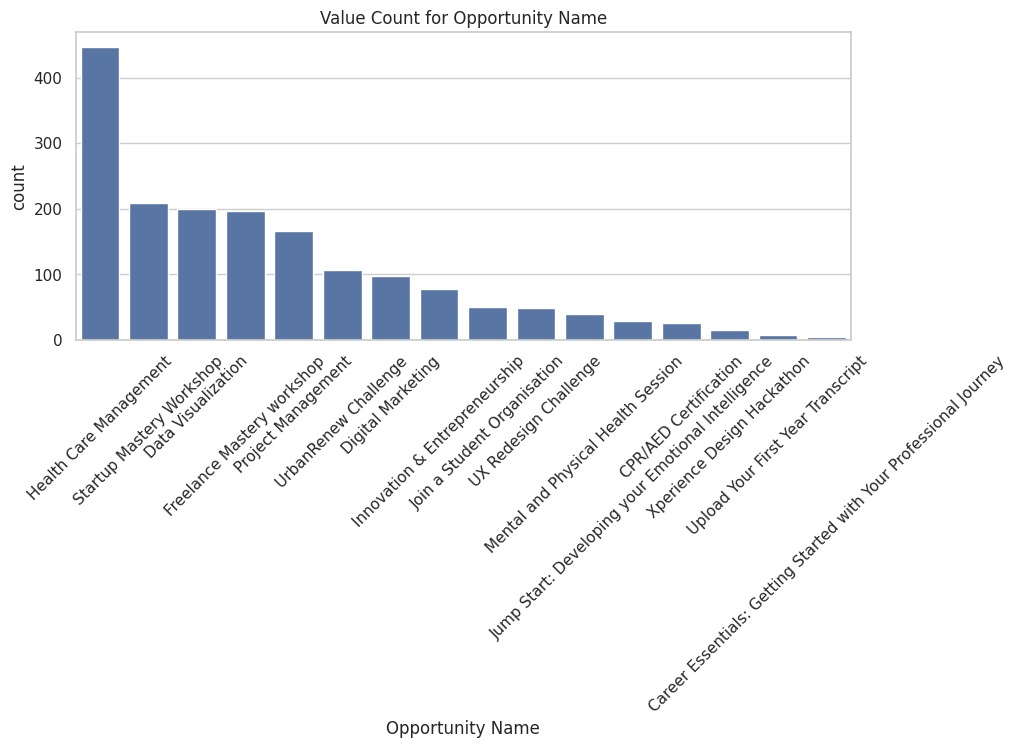

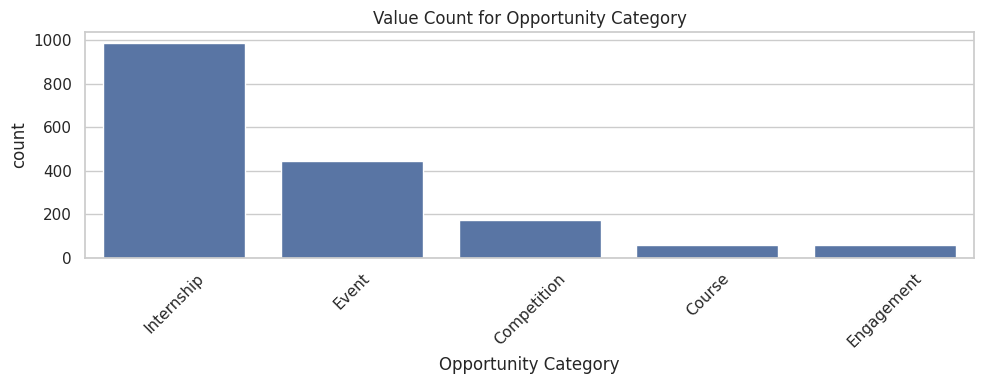

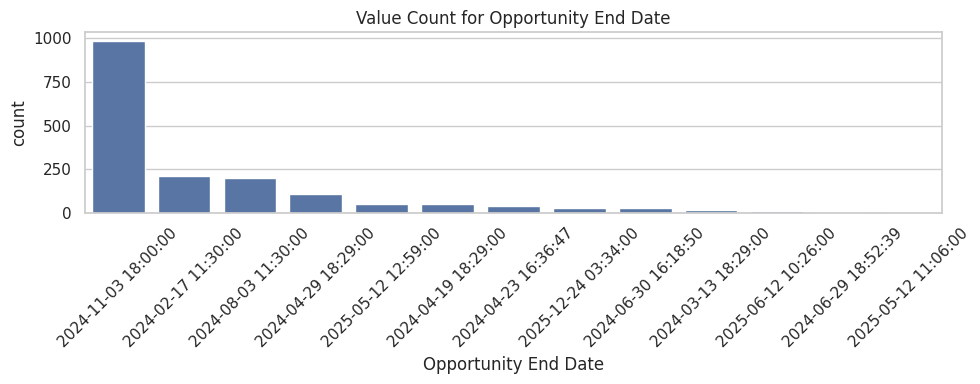

In [ ]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols[:5]:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Value Count for {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Step 7 : Correlation and Heatmap

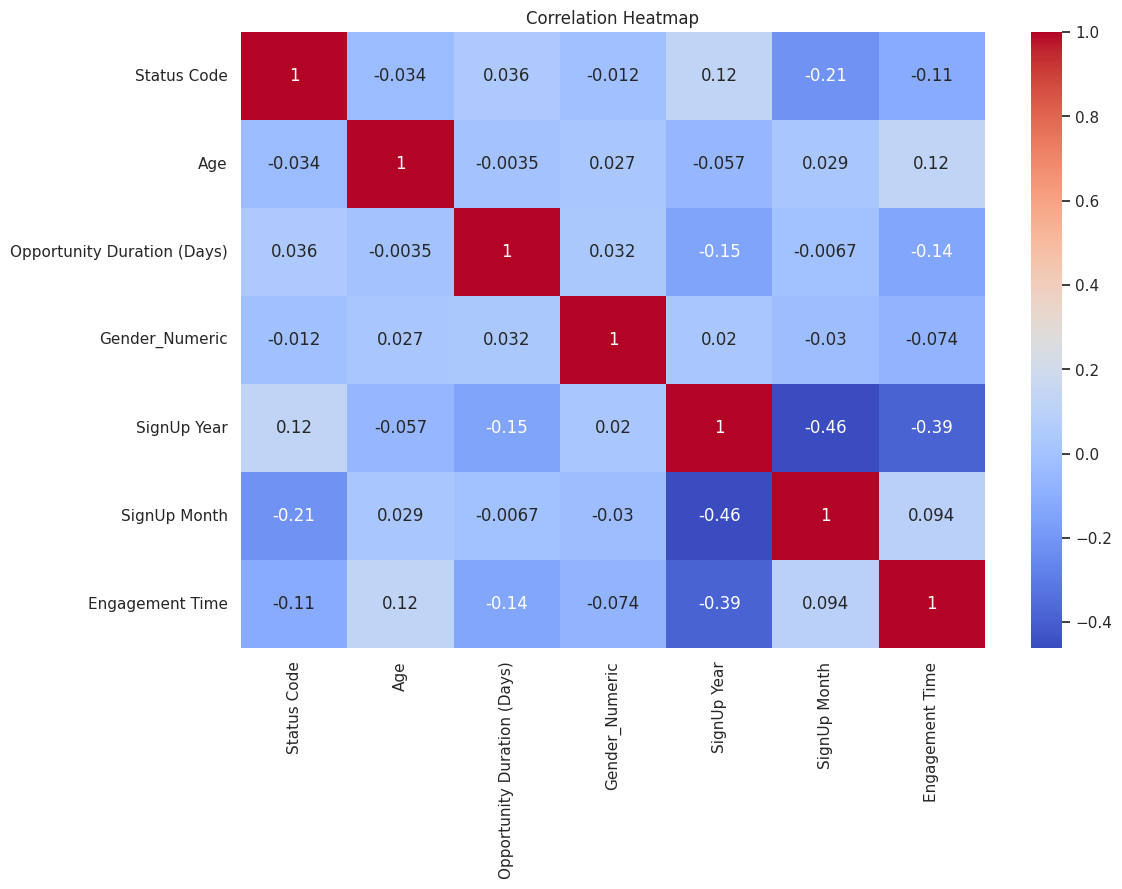

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## Step 8 : Visual Trends and Relationships

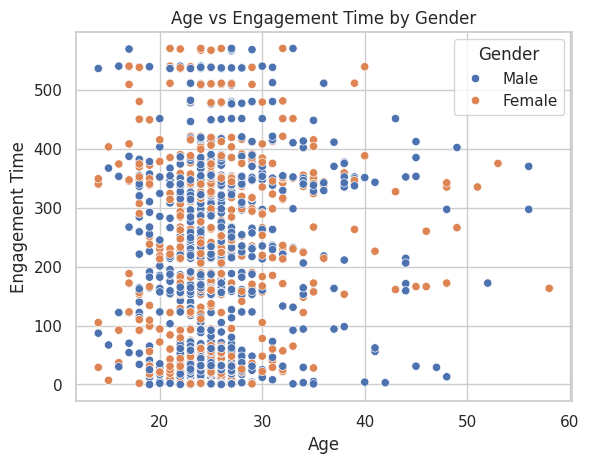

In [ ]:
sns.scatterplot(data=df, x='Age', y='Engagement Time', hue='Gender')
plt.title("Age vs Engagement Time by Gender")
plt.show()

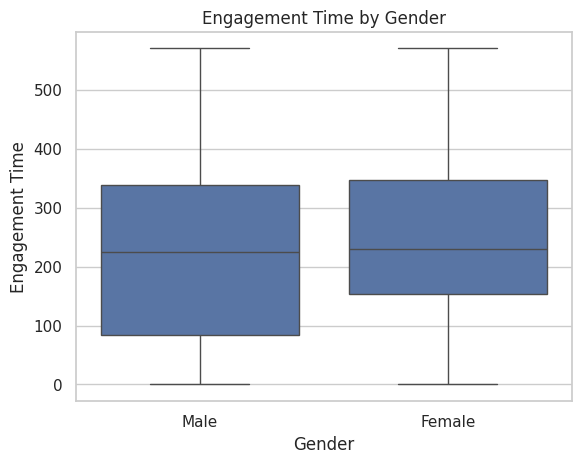

In [ ]:
sns.boxplot(data=df, x='Gender', y='Engagement Time')
plt.title("Engagement Time by Gender")
plt.show()

## Step 9 : Insight Generation


Insights:
- Users in the 20–26 age group show variable engagement time.
- Certain majors or institutions dominate participation.
- Gender-based distribution shows imbalance in some opportunities.

We can now develop hypotheses from these observations.


## Step 10 : Hypothesis Development


Based on the EDA, we propose the following hypotheses:

1. Learners aged 24+ have higher engagement time due to academic maturity.
2. Institutions with established digital learning culture show higher sign-up and engagement.
3. Females might show different engagement patterns compared to males.

These hypotheses can be tested using statistical tests or predictive modeling.


## Step 11 : Preparing for Predictive Modeling


With clean, structured, and understood data, we are ready to move into predictive modeling:
- Select relevant features (based on correlation, variance, domain knowledge)
- Normalize/scale numeric values
- Encode categorical variables

This ensures high model performance and valid results.


# Week 3 
# Predictive Modelling

## Step 1 : Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Correct path to your Excel file
file_path = '/content/drive/My Drive/all correct/correct_dataset.xlsx'

# Read the Excel file using openpyxl engine
df = pd.read_excel(file_path, engine='openpyxl')

# Display the first few rows
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Learner SignUp DateTime                  Opportunity Id  \
0     2023-06-14 12:30:35  00000000-0GN2-A0AY-7XK8-C5FZPP   
1     2023-01-05 05:29:16  00000000-0GN2-A0AY-7XK8-C5FZPP   
2     2023-09-04 20:35:08  00000000-0GN2-A0AY-7XK8-C5FZPP   
3     2023-08-29 05:20:03  00000000-0GN2-A0AY-7XK8-C5FZPP   
4     2023-06-01 15:26:36  00000000-0GN2-A0AY-7XK8-C5FZPP   

                                    Opportunity Name Opportunity Category  \
0  Career Essentials: Getting Started with Your P...               Course   
1  Career Essentials: Getting Started with Your P...               Course   
2  Career Essentials: Getting Started with Your P...               Course   
3  Career Essentials: Getting Started with Your P...               Course   
4  Career Essentials: Getting Started with Your P...               Course   

  Opportunity End Date        First Name 

## Step 2 : Importing necessary libararies

In [ ]:
# Churn Prediction Pipeline for Internship Platform

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Step 3 : Selecting features for model training

In [ ]:
# Load data
df = pd.read_excel(file_path)
# Clean column names
df.columns = df.columns.str.strip()

# Create 'Churn' column
df['Churn'] = (df['Status Description'] == 'Dropped Out').astype(int)

# Feature engineering
df['SignUp Year'] = pd.to_datetime(df['Learner SignUp DateTime']).dt.year
df['SignUp Month'] = pd.to_datetime(df['Learner SignUp DateTime']).dt.month

# Select features
features = [
    'Engagement Duration',
        'Time in Opportunity',
            'Age',
                'SignUp Year',
                    'SignUp Month',
                        'Gender',
                            'Country',
                                'Opportunity Category'
                                ]

## Step 4 :  Plot distribution of Engagement Duration by churn

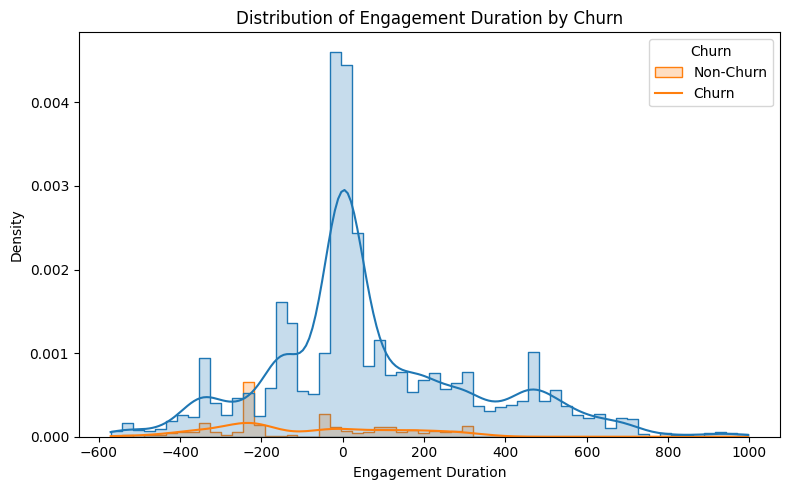

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns

# Remove any trailing spaces just in case
df.columns = df.columns.str.strip()

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(
x=df['Engagement Duration'],
hue=df['Churn'],
kde=True,
element='step',stat='density'
)

plt.title('Distribution of Engagement Duration by Churn')
plt.xlabel('Engagement Duration')
plt.ylabel('Density')
plt.legend(title='Churn', labels=['Non-Churn', 'Churn'])
plt.tight_layout()
plt.show()

## Step 5 : Creating necessary pipelines and splitting the data

In [ ]:
X = df[features]
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

In [ ]:
# Preprocessing
numeric_features = ['Engagement Duration', 'Time in Opportunity', 'Age', 'SignUp Year', 'SignUp Month']
categorical_features = ['Gender', 'Country', 'Opportunity Category']

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ])

# Pipelines
logistic_pipeline = Pipeline([
            ('preprocessor', preprocessor),
                ('classifier', LogisticRegression(max_iter=1000))
                ])
rf_pipeline = Pipeline([
               ('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
                        ])

## Step 6 : Training and Evaluation

In [ ]:
# Train models
logistic_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

# Evaluate models
print("=== Logistic Regression ===")
y_pred_log = logistic_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_log, digits=3))

print("=== Random Forest ===")
y_pred_rf = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_rf, digits=3))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.939     0.994     0.966      1589
           1      0.700     0.171     0.275       123

    accuracy                          0.935      1712
   macro avg      0.820     0.583     0.620      1712
weighted avg      0.922     0.935     0.916      1712

=== Random Forest ===
              precision    recall  f1-score   support

           0      0.947     0.970     0.959      1589
           1      0.440     0.301     0.357       123

    accuracy                          0.922      1712
   macro avg      0.694     0.636     0.658      1712
weighted avg      0.911     0.922     0.915      1712



## Step 7 : Confusion Matrices

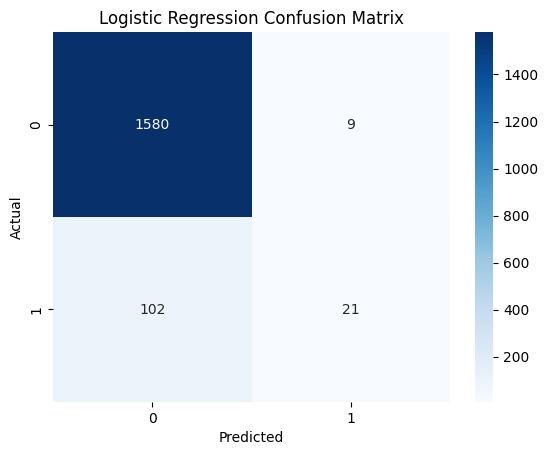

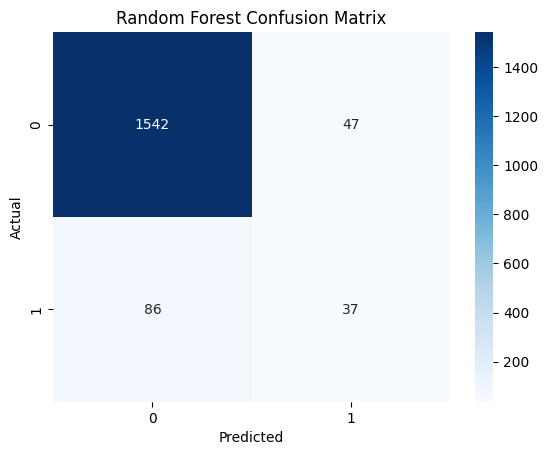

In [ ]:
# Confusion matrices
def plot_conf_matrix(y_true, y_pred, title):
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title(title)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

plot_conf_matrix(y_test, y_pred_log, "Logistic Regression Confusion Matrix")
plot_conf_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")

## Step 8 : Feature Importances

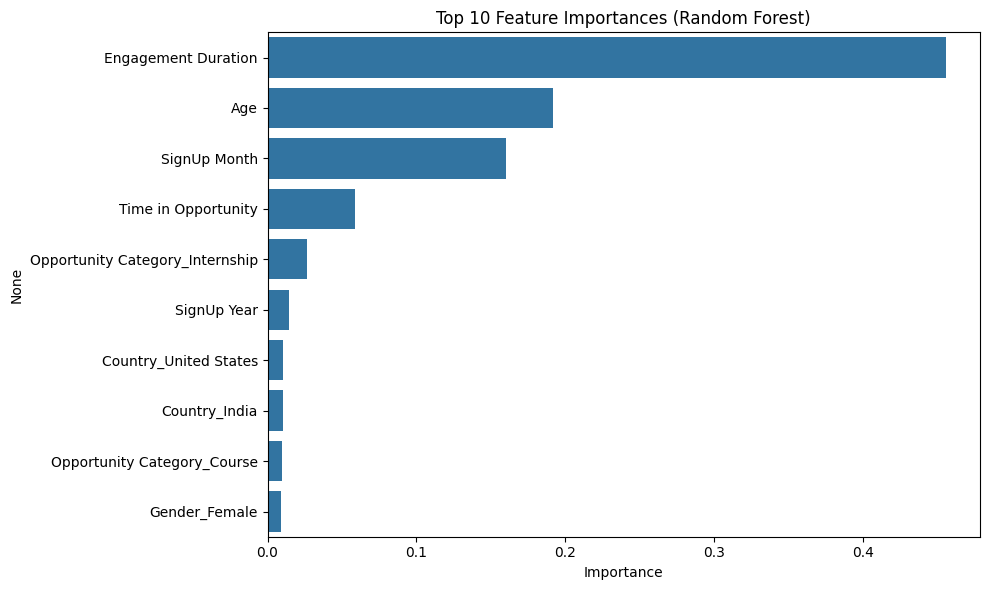

In [ ]:
# Feature importances
rf_model = rf_pipeline.named_steps['classifier']
ohe = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_feature_names = ohe.get_feature_names_out(categorical_features)
final_feature_names = numeric_features + list(encoded_feature_names)

importances = rf_model.feature_importances_
feat_importance = pd.Series(importances, index=final_feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance[:10], y=feat_importance.index[:10])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Step 9 : ROC Curve

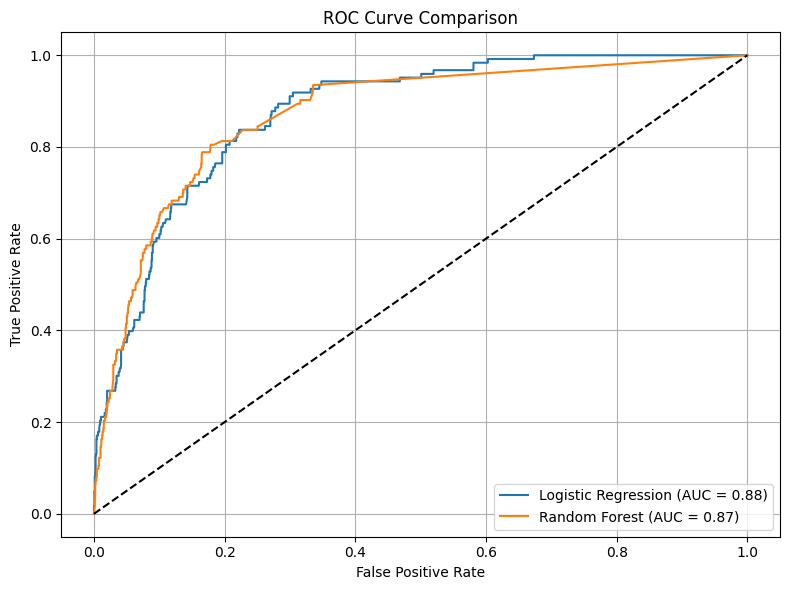

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Get probability scores
y_score_log = logistic_pipeline.predict_proba(X_test)[:, 1]
y_score_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# ROC values
fpr_log, tpr_log, _ = roc_curve(y_test, y_score_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)

# AUC
roc_auc_log = auc(fpr_log, tpr_log)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Diagonal line (baseline)
plt.plot([0, 1], [0, 1], 'k--')

# Labels
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Week 4

#  Internship Final Project: Recommendation System

This notebook implements a basic rule-based recommendation system using insights derived from Weeks 1–3:
- **Week 1:** Feature engineering
- **Week 2:** EDA insights
- **Week 3:** Churn modeling

The goal is to generate personalized recommendations to enhance student engagement and reduce drop-offs.

## Step 1: Load the Cleaned Dataset

In [ ]:
import pandas as pd

# Load dataset (update file path if needed)
file_path = "/content/Cleaned_Preprocessed_Dataset.xlsx - Sheet1.csv"
df = pd.read_csv(file_path)

df.head()

,Learner SignUp DateTime,Opportunity Id,Opportunity Name,Opportunity Category,Opportunity End Date,First Name,Date of Birth,Gender,Country,Institution Name,...,Apply Date,Opportunity Start Date,Age,Apply Date copy,Opportunity Start Date copy,Engagement Duration,Time in Opportunity,SignUp Year,SignUp Month,Gender_Encoded
0,2023-06-14 12:30:35,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Faria,2001-12-01 00:00:00,Female,Pakistan,Nwihs,...,2023-06-14 12:36:09,2022-03-11 18:30:39,23,2023-06-14 12:36:09,2022-03-11 18:30:39,459,841,2023,6,1
1,2023-01-05 05:29:16,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Poojitha,2000-08-16 00:00:00,Female,India,SAINT LOUIS,...,2023-01-05 06:08:21,2022-03-11 18:30:39,24,2023-01-05 06:08:21,2022-03-11 18:30:39,299,841,2023,1,1
2,2023-09-04 20:35:08,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Emmanuel,2002-01-27 00:00:00,Male,United States,Illinois Institute of Technology,...,2023-09-04 20:35:08,2022-03-11 18:30:39,23,2023-09-04 20:35:08,2022-03-11 18:30:39,542,841,2023,9,0
3,2023-08-29 05:20:03,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Amrutha Varshini,1999-01-11 00:00:00,Female,United States,Saint Louis University,...,2023-09-10 22:02:42,2022-03-11 18:30:39,26,2023-09-10 22:02:42,2022-03-11 18:30:39,548,841,2023,8,1
4,2023-06-01 15:26:36,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Vinay Varshith,2000-04-19 00:00:00,Male,United States,Saint Louis University,...,2023-06-01 15:40:10,2022-03-11 18:30:39,25,2023-06-01 15:40:10,2022-03-11 18:30:39,446,841,2023,6,0


## Step 2: Define Recommendation Logic

In [ ]:
def generate_recommendations(row):
    recs = []

    # Rule 1: Low engagement
    if row['Engagement Duration'] < 200:
        recs.append("Send motivational email or onboarding tutorial")
        recs.append("Assign mentor for weekly check-ins")

    # Rule 2: Younger learners
    if int(row['Age']) < 23:
        recs.append("Offer time management webinar or peer buddy system")

    # Rule 3: Internships (higher churn risk)
    if row['Opportunity Category'].lower() == 'internship':
        recs.append("Provide internship readiness workshop")

    # Rule 4: Late sign-up (short time before opportunity)
    if row['Time in Opportunity'] < 500:
        recs.append("Send early access prep materials and reminders")

    # Rule 5: Gender-based engagement (EDA showed males varied more)
    if row['Gender'] == 'Male':
        recs.append("Encourage consistent engagement via weekly nudges")

    # Fallback
    if not recs:
        recs.append("Continue with regular progress tracking")

    return "; ".join(recs)

##  Step 3: Generate Recommendations

In [ ]:
# Clean column names
df.columns = df.columns.str.strip()

# Now apply the function
df['Recommendations'] = df.apply(generate_recommendations, axis=1)
df[['First Name', 'Age', 'Gender', 'Engagement Duration', 'Opportunity Category', 'Time in Opportunity', 'Recommendations']].head()


,First Name,Age,Gender,Engagement Duration,Opportunity Category,Time in Opportunity,Recommendations
0,Faria,23,Female,459,Course,841,Continue with regular progress tracking
1,Poojitha,24,Female,299,Course,841,Continue with regular progress tracking
2,Emmanuel,23,Male,542,Course,841,Encourage consistent engagement via weekly nudges
3,Amrutha Varshini,26,Female,548,Course,841,Continue with regular progress tracking
4,Vinay Varshith,25,Male,446,Course,841,Encourage consistent engagement via weekly nudges


##  Step 4: Save Output

In [ ]:
df.to_csv("Student_Recommendations_Output.csv", index=False)
print("Recommendations saved to 'Student_Recommendations_Output.csv'")

Recommendations saved to 'Student_Recommendations_Output.csv'
